In [1]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import time as t

In [2]:
from gym import envs
envids = [spec.id for spec in envs.registry.all()]
'''for envid in sorted(envids):
    print(envid) '''

'for envid in sorted(envids):\n    print(envid) '

In [3]:
#To improve the velocity, run it on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device ', device)


#Create the enviorment
env = gym.make('LunarLander-v2')


env.seed(101) #To ensure it's the same situation always simulated, even if it's random
np.random.seed(101)

#check the properties of the enviorment
print('observation space:', env.observation_space) #states, is continuous 2-D (a box)
print('action space:', env.action_space) #actions, 1 discrete action, with 3 possible values
# print('  - low:', env.action_space.low) #minimum speed
# print('  - high:', env.action_space.high) #maximus speed
#t.sleep(10)

Device  cuda:0
observation space: Box(8,)
action space: Discrete(4)


/home/sergi/anaconda3/envs/Train/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
print( env.observation_space.shape[0] ) #First layer number of states+
h_size=16
# 1 action ,0 nothing, 1 left, 2 up , 3 right
        

8


In [5]:
#In this case exist 4 movements which can be positive or 0

#Creation of a class to chosse the actions, the policy
class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__() #Equivalent to super().__init__()
                                      #Means that this class heritage the init from nn.Module class
                                      # nn.Module it's the base class for all the neural net networks
                                      # https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module
                                      # https://pytorch.org/docs/stable/nn.html
        
        self.env = env #Save the enviorment as the Gym enviorment
        
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0] #First layer number of states+
        self.h_size = h_size #hidden layer
        self.a_size = 1 #Last layer number of actions ( 0 don't do nothing, 1 left, 2 up,3right)
        
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size) # A linear layer that connect the states with the hidden layer
        self.fc2 = nn.Linear(self.h_size, self.a_size) # Hidden layer the from hidden layer to actions
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        
#         print(s_size)
#         print(h_size)
#         print(a_size)
        
       
        # Are linear layers so 
        # weight _w and b it's the bias.
        #https://medium.com/datathings/linear-layers-explained-in-a-simple-way-2319a9c2d1aa
        
        
        #The bias learns a constant value, independent of the input.
        
        # Learns that all the positive states need at least a bias constant + something dependant
        
        # a linear layer learns that the output ,it's the Activation Function ( input * pendent (the weight) + constant)
        
        # linear neuron output = input *w + b
        
        # separate the weights for each layer
        
        # so we are saying that (state1 * wl1 + bl1)*wl2 +bl2, so we belive it follows a 1st order equation * activation function
        
        
        
        fc1_end = (s_size*h_size)+h_size 
        #The first states * number of hidden layers are the weights of the first layer, each network has different weights for each state input
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        #From the previous end , the follwing hidden layer neurons number weights are the bias, each neuron has only 1 bias, doesn't depend on the state input
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        
        #Every neuron has a weight for each action output
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
       
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        #In reality its returning the weights + bias dimensions, the +1 its the bias
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        #forward its Method to be able to pass the data as batches of data
        # It passes the data as Matrices adding the activation functions at the same time
        
        #They have activation functions to
        
        #https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6
        
        x = F.relu(self.fc1(x)) # Only possitive values pass
        #x = F.tanh(self.fc2(x))
        x = torch.sigmoid(self.fc2(x)) # Only from 0 to 1, to have easy to do 4 groups
        
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        # Obtain the accumulative reward from the actions selected by the neural net
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            #print(action)
            action = action *3
            if(action >= 2.5):
                action = 3
            elif (action >= 1.5):
                action = 2
            elif (action >= 0.5):
                action = 1
            else:
                action = 0
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
#End of class



In [6]:
agent = Agent(env).to(device) # Creation of a neural net in the device, in my case the GPU

In [7]:
#Cross Entrophy Method, to choose the weights
def cem(n_iterations=1000, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    #Fracció de millors pesos que et quedas
    n_elite=int(pop_size*elite_frac)
    
    #scores doble end queee , from 100 values
    scores_deque = deque(maxlen=100)
    #intial scores empty
    scores = []
    
    #Initial best weights, are from 0 to 1, it's good to be small the weights, but they should be different from 0.
    # small to avoid overfiting , different from 0 to update them
    best_weight = sigma*np.random.randn(agent.get_weights_dim())

    #Each iteration, modify  + 1 to 0 the best weight randomly
    #Computes the reward with these weights
    #Sort the reward to get the best ones
    # Save the best weights
    # the Best weight it's the mean of the best one
    #compute the main reward of the main best rewards ones
    #this it's show to evalute how good its
    for i_iteration in range(1, n_iterations+1):
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        #save the check point
        torch.save(agent.state_dict(), 'checkpointLunar.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores


Episode 10	Average Score: -138.02
Episode 20	Average Score: -122.92
Episode 30	Average Score: -123.83
Episode 40	Average Score: -142.36
Episode 50	Average Score: -141.61
Episode 60	Average Score: -142.12
Episode 70	Average Score: -131.60
Episode 80	Average Score: -124.78
Episode 90	Average Score: -121.56
Episode 100	Average Score: -115.21
Episode 110	Average Score: -108.65
Episode 120	Average Score: -104.14
Episode 130	Average Score: -101.99
Episode 140	Average Score: -92.96
Episode 150	Average Score: -101.65
Episode 160	Average Score: -101.11
Episode 170	Average Score: -110.97
Episode 180	Average Score: -127.75
Episode 190	Average Score: -139.04
Episode 200	Average Score: -148.53
Episode 210	Average Score: -153.19
Episode 220	Average Score: -158.46
Episode 230	Average Score: -161.63
Episode 240	Average Score: -159.85
Episode 250	Average Score: -146.39
Episode 260	Average Score: -142.12
Episode 270	Average Score: -132.97
Episode 280	Average Score: -119.13
Episode 290	Average Score: -11

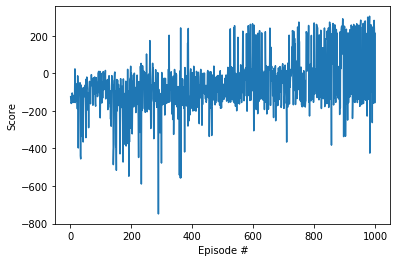

In [8]:
#Execute the cross entrophy method with default Values
#scores = cem()


#To don't ask the GPU as much reduce the pop_size, it's the amount of elemts try
scores = cem(pop_size=30)
# 
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
# load the weights from file
agent.load_state_dict(torch.load('checkpoint.pth'))

state = env.reset()
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
        action = action *3
        if(action >= 2.5):
            action = 3
        elif (action >= 1.5):
            action = 2
        elif (action >= 0.5):
            action = 1
        else:
            action = 0
    env.render()
    t.sleep(0.1)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

In [10]:
env.close()

In [12]:
#save the check point
torch.save(agent.state_dict(), 'checkpointLunar.pth')